<a href="https://colab.research.google.com/github/HancockJ/BOC405/blob/master/Jack_and_Vincent_EE576_Differential_Power_Analysis_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Differential Power Analysis or DPA is a technique that exploits the dependency of the processed data on the power trace of the device to extract some secret information that would not be otherwise available. The goal of this problem is for you to develop the software needed to carry out a DPA attack. 

## Problem 1 (5 points): Briefly explain the key steps of DPA



DPA stands for Differential Power Analysis and is a side channel attack that analyses the power consupmtion of electronics in order to obtain unauthorized information. There are 5 steps:

1) Choose and intermediate value that depends on the data and the unknown key

2) Measure the power traces when the device is encrypting some data

3) Build a matrix of hypothetical/possible itermediate values for all possible keys and traces

4) Use a power model to compute the matrix of hypothetical power consumption for all keys and traces

5) Statistically determine which hypothetical keys best matches themeasured power at each individual time

## Problem 2 (10 points): I/O Routines

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


You are provided with two sets of power-trace data. 

The first set is created using a known key (00 11 22 33 44 55 66 77 88 99 aa bb cc dd ee ff) so that you can use it to test and debug your code. There are two files:
*   [plaintext-00112233445566778899aabbccddeeff.txt](https://drive.google.com/file/d/1LkKrftocTM93OvrB_p2d1HxY-L7Iokys/view?usp=sharing) \\
This is a text file containing 200 traces (one trace per row) of 16 8-bit plaintext numbers. 
*   [traces-00112233445566778899aabbccddeeff.bin](https://drive.google.com/file/d/1Tu5rZz_iU6aOzn6qN_lMU6Ijud6XGGOz/view?usp=sharing) \\
This is a binary file that contains 370,000 current measurements for each of the 200 traces. Each measurement is represented as an unsigned 8-bit number.

The second set is created using an unknown key and the objective is to find that unknown key. This set has 150 traces. Each trace uses 16 8-bit plaintext numbers and collects 550,000 current measurements.
*   [plaintext.txt](https://drive.google.com/file/d/1HQOOfBLN_utQa8oSgw1drNYwPl5o9fOP/view?usp=sharing)
*   [traces.bin](https://drive.google.com/file/d/1mLuicDNzyk4OTt6nRQxj9KTDjScYh49f/view?usp=sharing)

You are asked to carry out three tasks: 
1.   Download all these files and re-upload to your colab environment. 
2.   Utilized the following routines to load these matrices - you only need to show the code for loading the second set.
3.   Use plyplot to plot out the current measurements for the first trace from the second set. I have already provided you with the plot but you will need to figure out the code. 





In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# routine to load plaintext and ciphtext files
# return an integer matrix of size numberOfTraces x 16
def txtload(fname, numberOfTraces):
  blocksize = 16                              # AES block size
  fp = open(fname,"r")
  x  = np.zeros([numberOfTraces,blocksize], dtype=int)
  for i in range(numberOfTraces):
    l = fp.readline()
    x[i,:] = [int(c,16) for c in l.split()]   # convert from hexadecimal string to integer
  fp.close()
  return x

# routine to load the binary current measurement file
# return an integer matrix of size numberTraces x traceSize
def binload(fname, numberOfTraces, traceSize):
  fp = open(fname,"rb")
  x  = np.fromfile(fp,np.dtype('uint8'),numberOfTraces*traceSize)
  x  = x.reshape([numberOfTraces,traceSize])
  return x

####################
# Parameters
####################
# modify following variables so they correspond your measurement setup

#tracefile      = "/traces.bin"
#plaintextfile  = "/plaintext.txt"
tracefile      = '/content/traces-00112233445566778899aabbccddeeff.bin'
plaintextfile  = '/content/plaintext-00112233445566778899aabbccddeeff.txt'
#numberOfTraces = 150
#traceSize      = 550000
numberOfTraces = 200
traceSize      = 370000

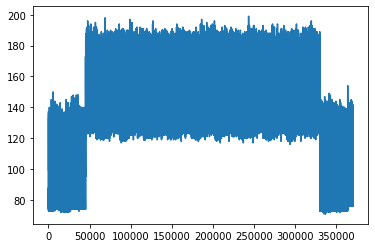

In [ ]:
####################
# LOADING the DATA 
####################

x = txtload(plaintextfile, numberOfTraces)
y = binload(tracefile, numberOfTraces, traceSize)

####################
# Plot the first trace 
####################
data = np.array(range(traceSize))

plt.plot(data, y[0])

plt.show()

## Problem 3 (15 points): Power Hypothesis

In this problem, you are asked to code up the routine to calculate power hypothesis. Power hypothesis is to use the input plaintext to calculate a quantity that correlates well with the current measurements. In class, we have already discussed that one such quantity is the hamming weight (number of 1's) of output of the SBOX in the first round of AES after the input plaintext number is XORed with the corresponding key value. 

The `powerHypothesis` routine should take as an input a vector `byteTrace` that corresponds to the plaintext number from each trace at a specific time - more specficially, `byteTrace` will be set to `plaintext[:,i]` where we iterate on the plaintext number from location `i` from all traces. 

The output of `powerHypothesis` should be a matrix of size `numberOfTraces` x 256. Entry (i,j) of this matrix should be the hamming weight of the SBOX output of the XOR result between the plaintext number at trace i and the candidate key j. 

To help you get started, I have already prepared the SBOX mapping for you. 



In [ ]:
# Declaration of the SBOX

SBOX=np.array([99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 
      202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 
      183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21,
      4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117,
      9, 131, 44, 26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132,
      83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207,
      208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168,
      81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210,
      205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115,
      96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219,
      224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121,
      231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8,
      186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138,
      112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193, 29, 158,
      225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223,
      140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22])


In [ ]:
def powerHypothesis(byteTrace):
  powerMatrix = np.zeros((numberOfTraces, 256))
  for i in range(numberOfTraces):
    for j in range(256):
      xor = (byteTrace[i] ^ j)
      powerMatrix[i][j] = bin(SBOX[xor])[2:].count('1')

  return powerMatrix

## Problem 4 (15 points): Correlation function 

In this problem, you are asked to write the `mycorr(A,B)` that takes in the `numberOfTraces`x256 matrix `A`, the output of `powerHypothesis`, and the `numberOfTraces`x`traceSize` current measurement matrix `B`, and returns a 256x`traceSize` correlation matrix C. 

As a reminder, the correlation function is computed as follows:

$C(i,j) = \left| \frac{(A(:,i)-\overline{A(:,i)})'\cdot(B(:,j)-\overline{B(:,j)})}{\lVert A(:,i) -\overline{A(:,i)}\rVert \cdot \lVert B(:,j) - \overline{B(:,j)}\rVert} \right|$



In [ ]:
def mycorr(A,B):
  C = np.zeros((256, traceSize))
  for i in range(256):
    for j in range(traceSize):
      topA = np.transpose(A[:,i] - np.mean(A[:,i]))
      topB = B[:,j] - np.mean(B[:,j])
      top = np.dot(topA, topB)
      
      bottomA = np.absolute(A[:,i] - np.mean(A[:,i]))
      bottomB = np.absolute(B[:,j] - np.mean(B[:,j]))
      bottom = np.dot(bottomA, bottomB)
      C[i,j] = np.absolute(top / bottom)
  

## Problem 5 (15 points): Putting everything together

Finally, in the last part of the assignment, you can put together both of the previous functions and prouduce the best guesses of the keys and the corresponding timestamps in the current measurement. The sample output on the testset is shown here as an example. 

In [ ]:
B = y
for i in range(16):
  key = -1
  trace = -1
  A = powerHypothesis(x[:,i])
  C = mycorr(A,B)
  max = -1
  for j in range(256):
    for k in range(traceSize):
      if(C[j,k] > max):
        max = C[j,k]
        key = j
        trace = k
  print("Position " + i + " - Best key = " + key + " - Time stamp = " + trace)